Table of contents:

[Repository and batch information](#repository-and-batch-information)

[Query data](#query-data)
  - [Make queries](#make-queries)
  - [Query and rename columns](#query-and-rename-columns)
  - [Query initial parameters](#query-initial-parameters)
  - [Data features](#data-features)
    - [Maximum and minimum values](#maximum-and-minimum-values)
    - [Maximum height](#maximum-height)
    - [Maximum flight range](#maximum-flight-range)
    - [Unique values](#unique-values)
    - [Number of unique values](#number-of-unique-values)

[Plots](#plots)
  - [Quick plots](#quick-plots)
    - [Quick x vs. y plot](#quick-x-vs.-y-plot)
    - [Time plot](#time-plot)

  - [Advanced plots](#advanced-plots)
    - [x vs. y plot](#x-vs.-y-plot)
    - [Subplots with a shared x-axis](#subplots-with-a-shared-x-axis)
    - [Ellipse error plot](#ellipse-error-plot)

[Statistics](#statistics)

[Correlation](#correlation)

[Validation](#validation)
  - [Check velocity standard deviation boundary](#check-velocity-standard-deviation-boundary)
  - [Check velocity standard deviation](#check-velocity-standard-deviation)
  - [Check mean velocity value](#check-mean-velocity-value)
  - [Check velocity of each simulation](#check-velocity-of-each-simulation)
  - [Check maximum distance](#check-maximum-distance)

The batch 'cannon_simulation_run' contains 10 simulations. 
For initial parameters, each simulation is assigned a unique initial angle, chosen from a normal distribution with a 
mean of 45 and a standard deviation of 15. The initial speed varies slightly: it's set to 50 for the first 
simulation and then increases uniformly by 1 for each subsequent simulation. Let's define the variable with the name of this batch as `my_batch`:

In [1]:
import os
print("report info")
print(os.getenv("REPORT_NANE"))
print(os.getenv("REPORT_MESSAGE"))
print(os.getenv("REPORT_VERSION"))

print("batch info")
print(os.getenv("BATCH_SIMULATION"))
print(os.getenv("BATCH_NAME"))
print(os.getenv("BATCH_VERSION"))
print(os.getenv("BATCH_MESSAGE"))

my_simulation = os.getenv("BATCH_SIMULATION")
my_batch = os.getenv("BATCH_NAME")

report info


NameError: name 'os' is not defined

Download the `data_access` module, which allows you to retrieve general information about the repositories and batches, as well as query and visualize data:

In [2]:
from citros import CitrosDB
citros = CitrosDB()

To get general information about the batch content, execute `info()` method. 

It returns dictionary, that contains:
   - 'size': size of the selected data
   - 'sid_count': number of sids
   - 'sid_list': list of the sids
   - 'topic_count': number of topics
   - 'topic_list': list of topics
   - 'message_count': number of messages

Show information about topics of the batch 'cannon_simulation_run':

In [3]:
citros.simulation(my_simulation).batch(my_batch).info().print()

{
 'size': '775 kB',
 'sid_count': 5,
 'sid_list': [0, 1, 2, 3, 4],
 'topic_count': 3,
 'topic_list': ['/cannon/state', '/config', '/scheduler'],
 'message_count': 4002
}


We see that 'cannon_simulation_run' contains 10 simulations and 3 topics. 
The data is stored under '/cannon/state' topic.

Let's show information for the topic '/cannon/state':

In [4]:
citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').info().print()

{
 'size': '409 kB',
 'sid_count': 5,
 'sid_list': [0, 1, 2, 3, 4],
 'topic_count': 1,
 'topic_list': ['/cannon/state'],
 'message_count': 1547,
 'topics': {
   '/cannon/state': {
     'type': 'std_msgs/msg/Float64MultiArray',
     'data_structure': {
       'data': {
         'data': 'list',
         '__msgtype__': 'str'
       }
     },
     'message_count': 1547
   }
 }
}


Let's display only information about the data structure:

In [5]:
citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').info()['topics']['/cannon/state']['data_structure'].print()

{
 'data': {
   'data': 'list',
   '__msgtype__': 'str'
 }
}


The initial parameters are stored in the '/config' topic. Typically, one topic corresponds to a single type. 
However, certain topics, like '/config', can encompass multiple types. 
Within '/config', each simulation scenario assigns a unique type to every simulation run (represented by each 'sid'). 
These types can be found under the 'type' keyword.

Furthermore, some types can vary in their data structure. 
Consequently, types are categorized based on their data structure and are labeled as 'type_group_0', 'type_group_1', and so forth.

Let's examine the '/config' topic in the 'cannon' repository as an example. 
Here, some type groups have differing data structures, yet they all correspond to the single '/config' topic:

In [6]:
citros.simulation(my_simulation).batch(my_batch).topic('/config').info().print()

{
 'size': '4240 bytes',
 'sid_count': 5,
 'sid_list': [0, 1, 2, 3, 4],
 'topic_count': 1,
 'topic_list': ['/config'],
 'message_count': 15,
 'topics': {
   '/config': {
     'type_group_0': {
       'type': ['.citros/data/simulation_cannon_analytic/citros/20240124094612/0/config/cannon_analytic.yaml', '.citros/data/simulation_cannon_analytic/citros/20240124094612/1/config/cannon_analytic.yaml', '.citros/data/simulation_cannon_analytic/citros/20240124094612/2/config/cannon_analytic.yaml', '.citros/data/simulation_cannon_analytic/citros/20240124094612/3/config/cannon_analytic.yaml', '.citros/data/simulation_cannon_analytic/citros/20240124094612/4/config/cannon_analytic.yaml'],
       'data_structure': {
         'data': {
           'analytic_dynamics': {
             'ros__parameters': {
               'dt': 'float',
               'init_angle': 'float',
               'init_speed': 'float'
             }
           }
         }
       }
     },
     'type_group_1': {
       'type': ['

## Query data

### Make queries

To query batch the method `data()` is used. The output is a pandas.DataFrame.

The simulated data is always written in 'data' column of the batch and has a json format. That means that it either contains json objects 
(in python correspond to dict format) or json arrays (which are correspond to list in python). Also they can be nested one into another.

As it can be seen from the previous output, column 'data' has two json objects: 'data.data' and 'data.\_\_msgtype__'.
Let's get values from 'data.data':

In [7]:
citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').data('data.data').head(5)

#As the output is a pandas.DataFrame, all its methods can be applied. The method head(n) retains only the first n rows

,sid,rid,time,topic,type,data.data
0,0,0,1706082373402026613,/cannon/state,std_msgs/msg/Float64MultiArray,"[8.054036255195282, 4.178629500000001, 25.9807..."
1,0,1,1706082373402927205,/cannon/state,std_msgs/msg/Float64MultiArray,"[8.313843876330614, 4.297728, 25.9807621135331..."
2,0,2,1706082373410028644,/cannon/state,std_msgs/msg/Float64MultiArray,"[8.573651497465946, 4.4158455000000005, 25.980..."
3,0,3,1706082373417063208,/cannon/state,std_msgs/msg/Float64MultiArray,"[8.833459118601278, 4.5329820000000005, 25.980..."
4,0,5,1706082373426895756,/cannon/state,std_msgs/msg/Float64MultiArray,"[9.09326673973661, 4.649137500000001, 25.98076..."


To get data from several json objects, pass them as a list to `data()` method:

In [8]:
citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').data(['data.data', 'data.__msgtype__']).head(5)

,sid,rid,time,topic,type,data.__msgtype__,data.data
0,0,0,1706082373402026613,/cannon/state,std_msgs/msg/Float64MultiArray,std_msgs/msg/Float64MultiArray,"[8.054036255195282, 4.178629500000001, 25.9807..."
1,0,1,1706082373402927205,/cannon/state,std_msgs/msg/Float64MultiArray,std_msgs/msg/Float64MultiArray,"[8.313843876330614, 4.297728, 25.9807621135331..."
2,0,2,1706082373410028644,/cannon/state,std_msgs/msg/Float64MultiArray,std_msgs/msg/Float64MultiArray,"[8.573651497465946, 4.4158455000000005, 25.980..."
3,0,3,1706082373417063208,/cannon/state,std_msgs/msg/Float64MultiArray,std_msgs/msg/Float64MultiArray,"[8.833459118601278, 4.5329820000000005, 25.980..."
4,0,5,1706082373426895756,/cannon/state,std_msgs/msg/Float64MultiArray,std_msgs/msg/Float64MultiArray,"[9.09326673973661, 4.649137500000001, 25.98076..."


When the `data()` method is called without any arguments, the entire content of the 'data' column is downloaded, 
with each json object separated into individual columns. 
Since there are only two json objects, the result will be identical to the previous case where the labels were explicitly 
listed and passed as an argument:

In [9]:
citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').data().head(5)

,sid,rid,time,topic,type,data.data,data.__msgtype__
0,0,0,1706082373402026613,/cannon/state,std_msgs/msg/Float64MultiArray,"[8.054036255195282, 4.178629500000001, 25.9807...",std_msgs/msg/Float64MultiArray
1,0,1,1706082373402927205,/cannon/state,std_msgs/msg/Float64MultiArray,"[8.313843876330614, 4.297728, 25.9807621135331...",std_msgs/msg/Float64MultiArray
2,0,2,1706082373410028644,/cannon/state,std_msgs/msg/Float64MultiArray,"[8.573651497465946, 4.4158455000000005, 25.980...",std_msgs/msg/Float64MultiArray
3,0,3,1706082373417063208,/cannon/state,std_msgs/msg/Float64MultiArray,"[8.833459118601278, 4.5329820000000005, 25.980...",std_msgs/msg/Float64MultiArray
4,0,5,1706082373426895756,/cannon/state,std_msgs/msg/Float64MultiArray,"[9.09326673973661, 4.649137500000001, 25.98076...",std_msgs/msg/Float64MultiArray


As mentioned in the 'cannon' repository description, the outcome of the simulation is an array of two coordinates and two velocities:
['position_x', 'position_y', 'velocity_x', 'velocity_y'].
To get, for example, only data corresponding to position_x, specify index 0:

In [10]:
citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').data('data.data[0]').head(5)

,sid,rid,time,topic,type,data.data[0]
0,0,0,1706082373402026613,/cannon/state,std_msgs/msg/Float64MultiArray,8.054036
1,0,1,1706082373402927205,/cannon/state,std_msgs/msg/Float64MultiArray,8.313844
2,0,2,1706082373410028644,/cannon/state,std_msgs/msg/Float64MultiArray,8.573651
3,0,3,1706082373417063208,/cannon/state,std_msgs/msg/Float64MultiArray,8.833459
4,0,5,1706082373426895756,/cannon/state,std_msgs/msg/Float64MultiArray,9.093267


To get only velocities, velocity_x and velocity_y:

In [11]:
citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').data(['data.data[2]','data.data[3]']).head(5)

,sid,rid,time,topic,type,data.data[3],data.data[2]
0,0,0,1706082373402026613,/cannon/state,std_msgs/msg/Float64MultiArray,11.9589,25.980762
1,0,1,1706082373402927205,/cannon/state,std_msgs/msg/Float64MultiArray,11.8608,25.980762
2,0,2,1706082373410028644,/cannon/state,std_msgs/msg/Float64MultiArray,11.7627,25.980762
3,0,3,1706082373417063208,/cannon/state,std_msgs/msg/Float64MultiArray,11.6646,25.980762
4,0,5,1706082373426895756,/cannon/state,std_msgs/msg/Float64MultiArray,11.5665,25.980762


To get data only for specific simulations, indicate them by `sid()` method before calling `data()`. 
For example, to get position_y data only for simulations 2 and 3:

In [12]:
citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid([0, 2]).data('data.data[1]')

,sid,rid,time,topic,type,data.data[1]
0,0,0,1706082373402026613,/cannon/state,std_msgs/msg/Float64MultiArray,4.178630
1,0,1,1706082373402927205,/cannon/state,std_msgs/msg/Float64MultiArray,4.297728
2,0,2,1706082373410028644,/cannon/state,std_msgs/msg/Float64MultiArray,4.415846
3,0,3,1706082373417063208,/cannon/state,std_msgs/msg/Float64MultiArray,4.532982
4,0,5,1706082373426895756,/cannon/state,std_msgs/msg/Float64MultiArray,4.649138
...,...,...,...,...,...,...
599,2,574,1706082395484920585,/cannon/state,std_msgs/msg/Float64MultiArray,0.506626
600,2,576,1706082395494506338,/cannon/state,std_msgs/msg/Float64MultiArray,0.349272
601,2,578,1706082395504746181,/cannon/state,std_msgs/msg/Float64MultiArray,0.190938
602,2,580,1706082395514411269,/cannon/state,std_msgs/msg/Float64MultiArray,0.031622


See the [documentation](https://citros.io/doc/docs_data_analysis) of the **citros_data_analysis** package to learn more 
about possible constraints and sampling methods that may be applied during querying.

### Query and rename columns

Let's retrieve data on positions and velocities, separate the array content into individual columns, and assign appropriate names to the columns
 of the resulting pandas.DataFrame:

In [13]:
column_names = ['position_x', 'position_y', 'velocity_x', 'velocity_y']
query = ['data.data['+str(i)+']' for i in range(len(column_names))]

F = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').data(query)
F.rename({query[i]: column_names[i] for i in range(len(query))}, axis = 1, inplace = True)

print(F)

      sid  rid                 time          topic  \
0       0    0  1706082373402026613  /cannon/state   
1       0    1  1706082373402927205  /cannon/state   
2       0    2  1706082373410028644  /cannon/state   
3       0    3  1706082373417063208  /cannon/state   
4       0    5  1706082373426895756  /cannon/state   
...   ...  ...                  ...            ...   
1542    4  644  1706082407276856968  /cannon/state   
1543    4  645  1706082407279128530  /cannon/state   
1544    4  646  1706082407280580960  /cannon/state   
1545    4  648  1706082407283893865  /cannon/state   
1546    4  650  1706082407295160551  /cannon/state   

                                type  velocity_y  position_y  position_x  \
0     std_msgs/msg/Float64MultiArray     11.9589    4.178630    8.054036   
1     std_msgs/msg/Float64MultiArray     11.8608    4.297728    8.313844   
2     std_msgs/msg/Float64MultiArray     11.7627    4.415846    8.573651   
3     std_msgs/msg/Float64MultiArray     11.664

### Query initial parameters

As it was stated at the beggining of the notebook, batch `my_batch` was created in cannon_analytic simulation, where the initial angle was 
chosen randomly around 45 degrees and the initial velocity was increased by one each simulation, starting at 50.
To get table with the initial parameters for cannon_analytic the following steps may be executed:

In [14]:

init_param = citros.simulation(my_simulation).batch(my_batch).topic('/config').data()
print(init_param)

    sid  rid  time    topic  \
0     0    0     0  /config   
1     0    0     0  /config   
2     0    0     0  /config   
3     1    0     0  /config   
4     1    0     0  /config   
5     1    0     0  /config   
6     2    0     0  /config   
7     2    0     0  /config   
8     2    0     0  /config   
9     3    0     0  /config   
10    3    0     0  /config   
11    3    0     0  /config   
12    4    0     0  /config   
13    4    0     0  /config   
14    4    0     0  /config   

                                                 type  \
0   .citros/data/simulation_cannon_analytic/citros...   
1   .citros/data/simulation_cannon_analytic/citros...   
2   .citros/data/simulation_cannon_analytic/citros...   
3   .citros/data/simulation_cannon_analytic/citros...   
4   .citros/data/simulation_cannon_analytic/citros...   
5   .citros/data/simulation_cannon_analytic/citros...   
6   .citros/data/simulation_cannon_analytic/citros...   
7   .citros/data/simulation_cannon_analytic/cit

## Data features

### Maximum and minimum values

For the simulation with sid = 0, let's determine the maximum and minimum values of 'position_y', which corresponds to the 'data.data[1]' column:

In [15]:
column_name = 'data.data[1]'

result_max = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid(0).get_max_value(column_name)
result_min = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid(0).get_min_value(column_name)

print(f"for sid = 0 max value of the column '{column_name}' : {result_max}")
print(f"for sid = 0 min value of the column '{column_name}' : {result_min}")

for sid = 0 max value of the column 'data.data[1]' : 11.467885499999996
for sid = 0 min value of the column 'data.data[1]' : 0.0


### Maximum height

Let's find the simulation, in which the maximum height is achieved and print the sid of the simulation, 
x coordinate when the maximum height is approached and the initial parameters of this simulation from table `init_param`, 
that we obtained in [Query initial parameters](#query-initial-parameters):

In [16]:
column_name = 'data.data[1]'

#set return_index = True to get the sid and rid of the max/min value
result_max, sid_max, rid_max = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').get_max_value(column_name, return_index = True)
# print(result_max, sid_max, rid_max)

x = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid(sid_max).rid(rid_max).data('data.data[0]')['data.data[0]'].iloc[0]

init_angle = init_param.set_index('sid').loc[sid_max]['data.analytic_dynamics.ros__parameters.init_angle']
init_speed = init_param.set_index('sid').loc[sid_max]['data.analytic_dynamics.ros__parameters.init_speed']
print(f"The maximum height is achieved in simulation {sid_max} at x = {x}")
print(f"the initial parameters are:\ninitial angel = {init_angle},\ninitial speed = {init_speed}")

The maximum height is achieved in simulation 4 at x = 50.93961425060073
the initial parameters are:
initial angel = sid
4     NaN
4     NaN
4    30.0
Name: data.analytic_dynamics.ros__parameters.init_angle, dtype: float64,
initial speed = sid
4     NaN
4     NaN
4    34.0
Name: data.analytic_dynamics.ros__parameters.init_speed, dtype: float64


### Maximum flight range

Let's find the simulation in which the maximum range of flight is achieved:

In [17]:
column_name = 'data.data[0]'

#set return_index = True to get the sid and rid of the max/min value
result_max, sid_max, rid_max = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').get_max_value(column_name, return_index = True)

init_angle = init_param.set_index('sid').loc[sid_max]['data.analytic_dynamics.ros__parameters.init_angle']
init_speed = init_param.set_index('sid').loc[sid_max]['data.analytic_dynamics.ros__parameters.init_speed']
print(f"The maximum flight range is achieved in simulation {sid_max}")
print(f"the initial parameters are:\ninitial angel = {init_angle},\ninitial speed = {init_speed}")

The maximum flight range is achieved in simulation 4
the initial parameters are:
initial angel = sid
4     NaN
4     NaN
4    30.0
Name: data.analytic_dynamics.ros__parameters.init_angle, dtype: float64,
initial speed = sid
4     NaN
4     NaN
4    34.0
Name: data.analytic_dynamics.ros__parameters.init_speed, dtype: float64


### Unique values

Print unique values by `get_unique_values()`. For example, one of the way to show all possible topics for the batch is the following:

In [18]:
column_names = 'topic'
result = citros.simulation(my_simulation).batch(my_batch).get_unique_values(column_names)

print(result)

['/scheduler', '/config', '/cannon/state']


To get unique combination of values, specify their labels as a list.
For example, to get unique combination of topic-type for the first simulation and print them as a table:

In [19]:
column_names = ['topic', 'type']
result = citros.simulation(my_simulation).batch(my_batch).sid(0).get_unique_values(column_names)

#print the result
from prettytable import PrettyTable
table = PrettyTable(field_names=column_names, align='r')
table.add_rows(result)
print(table)

+---------------+---------------------------------------------------------------------------------------------+
|         topic |                                                                                        type |
+---------------+---------------------------------------------------------------------------------------------+
| /cannon/state |                                                              std_msgs/msg/Float64MultiArray |
|       /config | .citros/data/simulation_cannon_analytic/citros/20240124094612/0/config/cannon_analytic.yaml |
|       /config |  .citros/data/simulation_cannon_analytic/citros/20240124094612/0/config/cannon_numeric.yaml |
|       /config |       .citros/data/simulation_cannon_analytic/citros/20240124094612/0/config/scheduler.yaml |
|    /scheduler |                                                                           std_msgs/msg/Bool |
+---------------+---------------------------------------------------------------------------------------

### Number of unique values

Print number of the unique values in the column "type" for the first simulation:

In [20]:
#name of the column:
column_name = 'type'

counts = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid([0]) .get_unique_counts(column_name)
print(f"number of unique values in column '{column_name}' for topic '/cannon/state': {counts[0][0]}")

#you may group the result, for example by topics:
group_by = 'topic'
counts = citros.simulation(my_simulation).batch(my_batch).sid([0]).get_unique_counts(column_name, group_by = group_by)

print(f"number of unique values in column '{column_name}':")
table = PrettyTable(field_names= [group_by, 'unique_counts'], align='r')
table.add_rows(counts)
table.border = False
print(table)

number of unique values in column 'type' for topic '/cannon/state': 1
number of unique values in column 'type':
         topic  unique_counts 
 /cannon/state              1 
       /config              3 
    /scheduler              1 


## Plots

### Quick plots

May be used to take a quick look on data without saving it.

#### Quick x vs. y plot

Plot 'position_y' vs. 'position_x' for sids = 1 and 2:

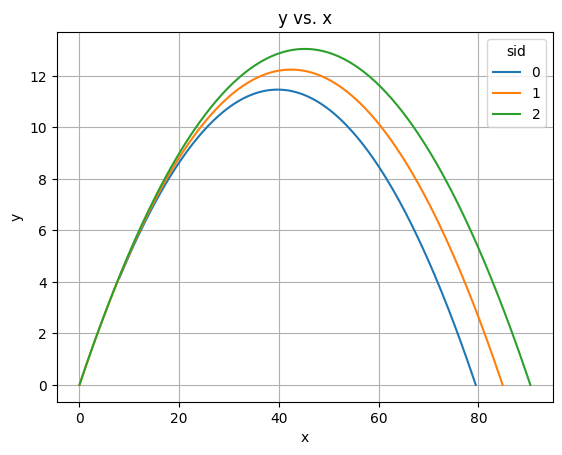

In [21]:
#import matplotlib
import matplotlib.pyplot as plt

#create a figure to plot on
fig, ax = plt.subplots()

citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid([0,1,2]).\
        xy_plot(ax, var_x_name = 'data.data[0]',var_y_name = 'data.data[1]',
                x_label = 'x', y_label = 'y', title_text = 'y vs. x')

#### Time plot

In the 'cannon' example, the simulation results are recorded at intervals defined by the `dt` parameter, 
which is established in the setup. By multiplying the simulation step, 'rid', by `dt`, we can create a time scale.

For the 'cannon_simulation_run' batch, the value of `dt` is set to 0.01.

Then, to plot 'y' against time, proceed as follows:

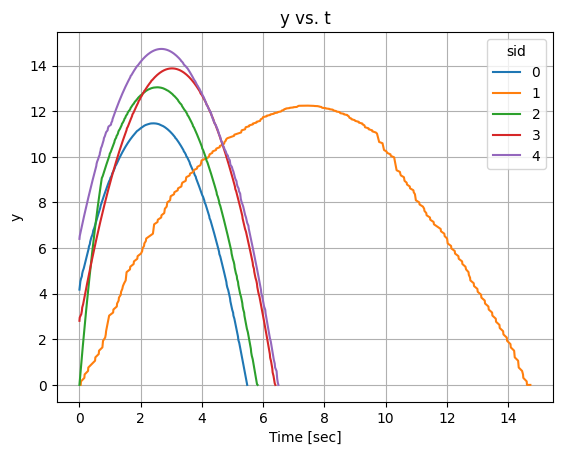

In [22]:
#import matplotlib
import matplotlib.pyplot as plt

#create a figure to plot on
fig, ax = plt.subplots()

citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid([0,1,2,3,4]).\
       time_plot(ax, var_name = 'data.data[1]', time_step = 0.01, y_label = 'y', title_text = 'y vs. t')

### Advanced plots

In all the following examples the matplotlib.Figure and matplotlib.Axes are returned, that may be used for further plotting.

Let's query data and label columns in the same way as it was done [previously](#query-and-rename-columns).
Let's also costruct a new column 't' based on 'rid' that represents time, as it was discussed [here](#time-plot).

In [23]:
column_names = ['position_x', 'position_y', 'velocity_x', 'velocity_y']
query = ['data.data['+str(i)+']' for i in range(len(column_names))]

F = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').data(query)
F.rename({query[i]: column_names[i] for i in range(len(query))}, axis = 1, inplace = True)

dt = 0.01
F['t'] = F['rid']*dt

print(F.head(5))

   sid  rid                 time          topic  \
0    0    0  1706082373402026613  /cannon/state   
1    0    1  1706082373402927205  /cannon/state   
2    0    2  1706082373410028644  /cannon/state   
3    0    3  1706082373417063208  /cannon/state   
4    0    5  1706082373426895756  /cannon/state   

                             type  velocity_y  position_y  position_x  \
0  std_msgs/msg/Float64MultiArray     11.9589    4.178630    8.054036   
1  std_msgs/msg/Float64MultiArray     11.8608    4.297728    8.313844   
2  std_msgs/msg/Float64MultiArray     11.7627    4.415846    8.573651   
3  std_msgs/msg/Float64MultiArray     11.6646    4.532982    8.833459   
4  std_msgs/msg/Float64MultiArray     11.5665    4.649138    9.093267   

   velocity_x     t  
0   25.980762  0.00  
1   25.980762  0.01  
2   25.980762  0.02  
3   25.980762  0.03  
4   25.980762  0.05  


#### x vs. y plot

Let's plot y vs. x. Check if the simulations ids when the the maximum height and maximum flight range are achieved are the same, 
as we determined previously in [Maximum height](#maximum-height) and [Maximum flight range](#maximum-flight-range) sections.

Text(0.5, 1.0, 'y vs. x')

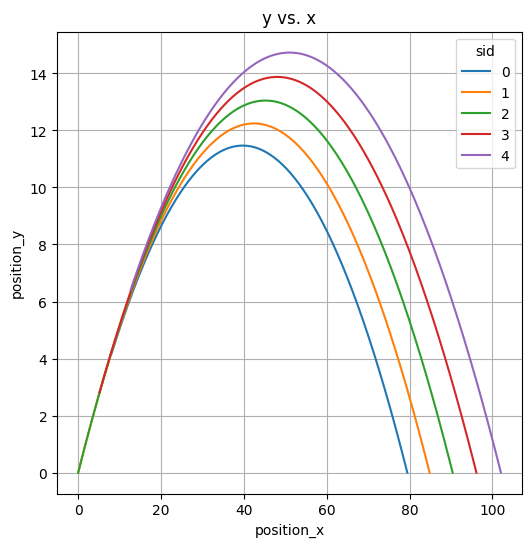

In [24]:
fig, ax = citros.plot_graph(F, 'position_x', 'position_y', '-')
ax.set_title('y vs. x')

#### Subplots with a shared x-axis

Plot 'position_y' vs 't' and 'velosity_y' vs. 't' on adjacent panels on one figure:

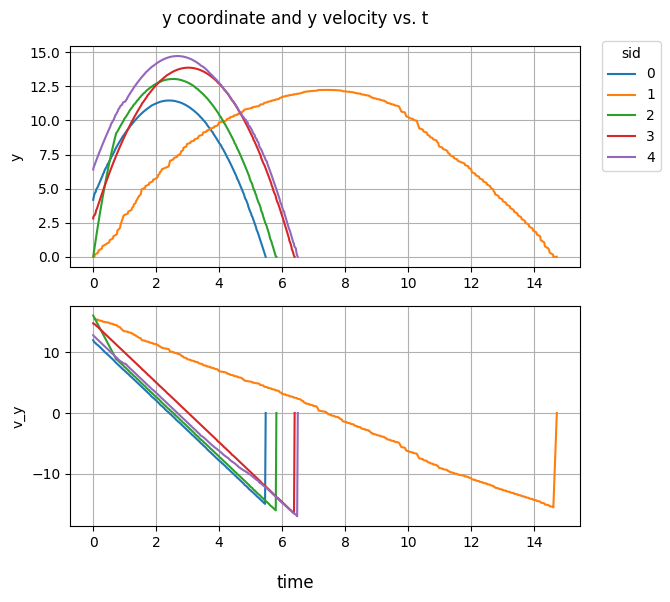

In [25]:
fig, ax = citros.multiple_y_plot(F, "t", ["position_y", "velocity_y"], '-', 
            legend = True, title = 'y coordinate and y velocity vs. t', set_x_label = 'time', set_y_label = ['y','v_y'])

### Ellipse error plot

Plot error ellipse for the initial values of the velocities:

sid numbers: [0, 1, 2, 3, 4]
rid first values: {0: 0, 1: 4, 2: 0, 3: 0, 4: 0}


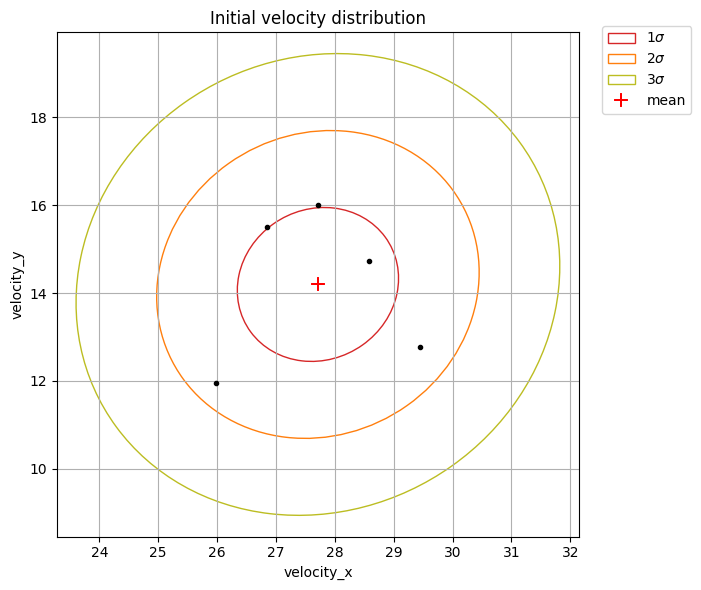

In [26]:
x = 'data.data[2]'
label_x = 'velocity_x'
y = 'data.data[3]'
label_y = 'velocity_y'

#get all possible sid:
sid_list = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').info()['sid_list']
#or using get_unique_values() method:
# sid_list = citros.batch(my_batch).topic('/cannon/state').get_unique_values('sid')
print(f"sid numbers: {sid_list}")

#for each sid get the first value of rid:
rid_dict = {}
for s in sid_list:
    rid_dict[s] = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid(s).get_min_value('rid')
print(f"rid first values: {rid_dict}")

# get the values of 'velocity_x' and 'velocity_y', that corresponds to the first rid:
# we are creating an empty DataFrame 'df', query for the values of the exact sid and rid and add the result to the 'df'.

import pandas as pd
df = pd.DataFrame()

for s, r in rid_dict.items():
    df = pd.concat([df, citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid(s).rid(r).data([x, y])])

df.rename({x: label_x, y: label_y}, axis = 1, inplace = True)

fig, ax, ellipse_param = citros.plot_sigma_ellipse(df, x_label = label_x, y_label = label_y, 
                                    n_std = [1,2,3], plot_origin=False, bounding_error=False,
                                    set_x_label=label_x, set_y_label = label_y, title = 'Initial velocity distribution',
                                    return_ellipse_param = True)

The returning ellipse parameters are presented in dict or in a list of dicts, if, as in this case, several error ellipses were plotted.
Let's print ellipse parameters of the 1-sigma ellipse:

In [27]:
ellipse_param_1 = ellipse_param[0]
print("ellipse parameters:")
print(f"center: {ellipse_param_1['x']}, {ellipse_param_1['y']}")
print(f"width: {ellipse_param_1['width']}, height: {ellipse_param_1['height']}")
print(f"angle: {ellipse_param_1['alpha']}\n")

ellipse parameters:
center: 27.71281292110204, 14.194959999999998
width: 3.5169003233558898, height: 2.716755205678138
angle: -98.89458543595983



Plot error ellipse for the values of "position_x" and "position_y" columns that corresponds to the last rid in each simulation.

We are expecting to get a spread in the x-coordinate and a value of exactly zero for the y-coordinate:

sid numbers: [0, 1, 2, 3, 4]
rid last numbers: {0: 548, 1: 1473, 2: 582, 3: 640, 4: 650}


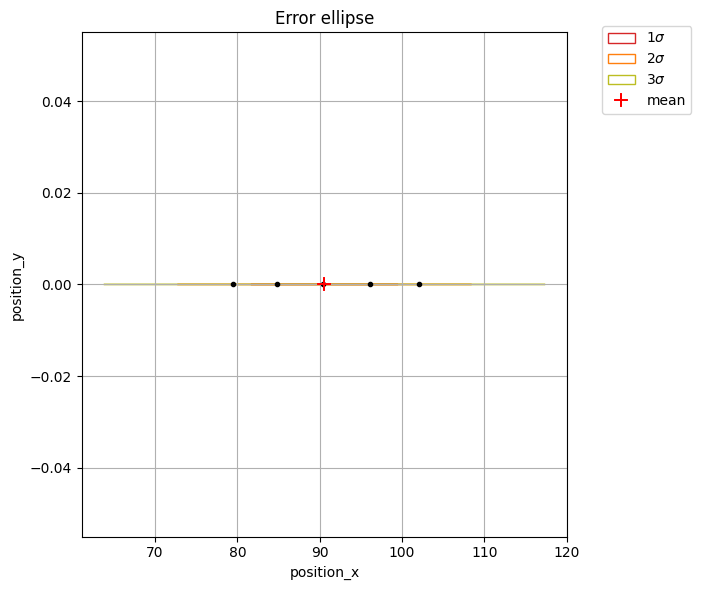

In [28]:
x = 'data.data[0]'
label_x = 'position_x'
y = 'data.data[1]'
label_y = 'position_y'

#get all possible sid:
sid_list = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').info()['sid_list']
#or using get_unique_values() method:
# sid_list = citros.batch(my_batch).topic('/cannon/state').get_unique_values('sid')
print(f"sid numbers: {sid_list}")


#for each sid get the last rid:
rid_dict = {}
for s in sid_list:
    rid_dict[s] = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid(s).get_max_value('rid')
print(f"rid last numbers: {rid_dict}")

# get the values of 'position_x' and 'position_y', that corresponds to the last rid:
# we are creating an empty DataFrame 'df', query for the values of the exact sid and rid and add the result to the 'df'.

import pandas as pd
df = pd.DataFrame()

for s, r in rid_dict.items():
    df = pd.concat([df, citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid(s).rid(r).data([x, y])])

df.rename({x: label_x, y: label_y}, axis = 1, inplace = True)

fig, ax, ellipse_param = citros.plot_sigma_ellipse(df, x_label = label_x, y_label = label_y, 
                                    n_std = [1,2,3], plot_origin=False, bounding_error=False,
                                    set_x_label=label_x, set_y_label = label_y, title = 'Error ellipse',
                                    return_ellipse_param = True)

## Statistics

Let's calculate statistics for the coordinates and velocities for 10 simulations in batch 'cannon_simulation_run'.

To analyze data from multiple simulations, it's essential to correlate the values across these various simulations.
One strategy is to designate an independent variable and establish a shared scale applicable to all simulations.
By assigning indexes on this scale, values of variables from different simulations can be interconnected using this independent variable.

Once again, let's download data and calculate time column 't' based on 'rid' and use it as an independent variable.

In [29]:
column_names = ['position_x', 'position_y', 'velocity_x', 'velocity_y']
query = ['data.data['+str(i)+']' for i in range(len(column_names))]

F = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').data(query)
F.rename({query[i]: column_names[i] for i in range(len(query))}, axis = 1, inplace = True)

dt = 0.01
F['t'] = F['rid']*dt

print(F.head(5))

   sid  rid                 time          topic  \
0    0    0  1706082373402026613  /cannon/state   
1    0    1  1706082373402927205  /cannon/state   
2    0    2  1706082373410028644  /cannon/state   
3    0    3  1706082373417063208  /cannon/state   
4    0    5  1706082373426895756  /cannon/state   

                             type  velocity_y  position_y  position_x  \
0  std_msgs/msg/Float64MultiArray     11.9589    4.178630    8.054036   
1  std_msgs/msg/Float64MultiArray     11.8608    4.297728    8.313844   
2  std_msgs/msg/Float64MultiArray     11.7627    4.415846    8.573651   
3  std_msgs/msg/Float64MultiArray     11.6646    4.532982    8.833459   
4  std_msgs/msg/Float64MultiArray     11.5665    4.649138    9.093267   

   velocity_x     t  
0   25.980762  0.00  
1   25.980762  0.01  
2   25.980762  0.02  
3   25.980762  0.03  
4   25.980762  0.05  


Let's show mean value of each of the coordinate and indicate 3-sigma standard deviation.
To assigne indexeces we divide the independent variable 't' into n ranges, assign an index to each interval, 
and calculate the averages of the data values for each simulation in each range:

/opt/homebrew/lib/python3.11/site-packages/citros_data_analysis/error_analysis/citros_data.py:1097: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


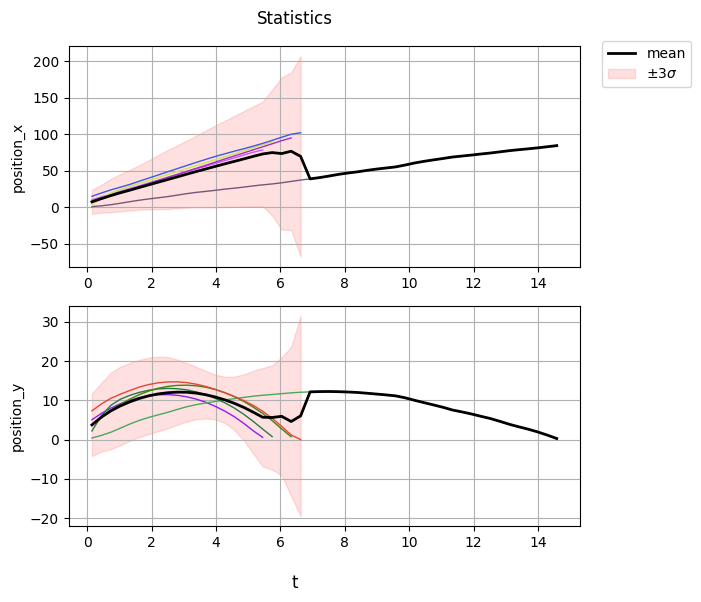

In [30]:
from citros_data_analysis import error_analysis as analysis
dataset = analysis.CitrosData(F, data_label=['position_x', 'position_y'])
db = dataset.bin_data(n_bins = 50, param_label = 't')
db.show_statistics(std_area = True, std_lines = False)

Time of flight is different for different simulations and depends on initial angle, so the end of the flight occurs at different times.
We can use slightly different approach: instead of binning, we can scale the independent variable to the interval [0,1], 
define a new range of n points uniformly distributed from 0 to 1, and interpolate data points over this new interval:

/opt/homebrew/lib/python3.11/site-packages/citros_data_analysis/error_analysis/citros_data.py:1097: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


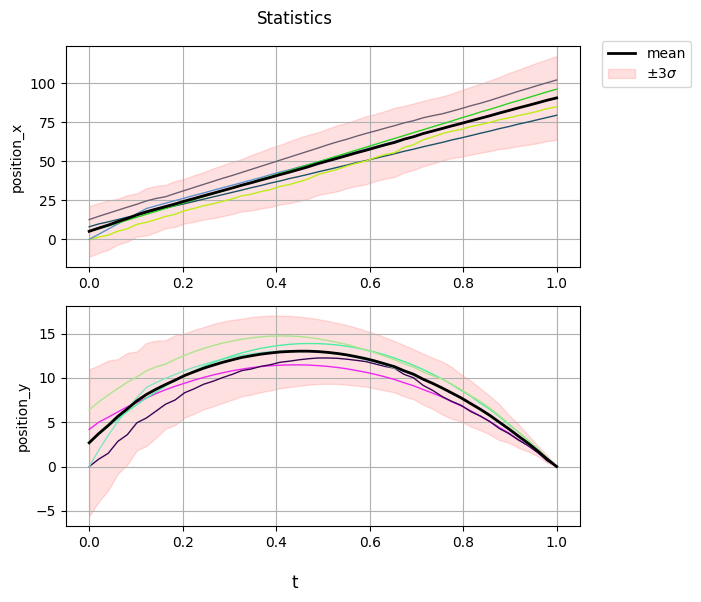

In [31]:
db = dataset.scale_data(n_points = 50, param_label = 't')
db.show_statistics(std_area = True, std_lines = False)

That way, time axis represents the fraction of the flight.

To get mean values, standard deviations and covariance matrixes, execute the following:

In [32]:
stat = db.get_statistics(return_format = 'citrosStat')

#`stat` now contains 3 attributes:
#the mean values (type - pandas.DataFrame):
print('mean values:\n', stat.mean.head(5))

#the standard deviation (type - pandas.DataFrame):
print('standard deviation:\n', stat.std.head(5))

#the covariance matrix (type - pandas.Series):
print('covariance matrix:\n', stat.covar_matrix.head(5))

mean values:
       position_x  position_y
t_id                        
0       5.171904    2.678555
1       7.226068    3.712156
2       9.156398    4.633602
3      11.383674    5.650772
4      13.418445    6.505993
standard deviation:
       position_x  position_y
t_id                        
0       5.428986    2.760846
1       5.310505    2.564494
2       5.252297    2.437437
3       4.893987    2.154058
4       4.952139    2.097523
covariance matrix:
 t_id
0    [[29.473890000000036, 14.98012528449933], [14....
1    [[28.2014669836174, 13.610022095240605], [13.6...
2    [[27.58662550083302, 12.788356314347814], [12....
3    [[23.95110583194505, 10.528679164657852], [10....
4    [[24.523683314244103, 10.370126746274586], [10...
Name: covar_matrix, dtype: object


Let's show the same statistics for the velocities:

/opt/homebrew/lib/python3.11/site-packages/citros_data_analysis/error_analysis/citros_data.py:1097: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


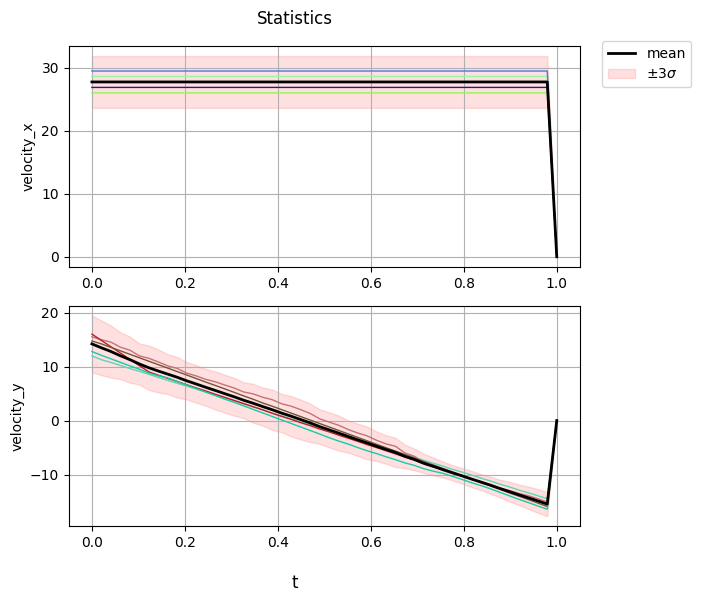

In [33]:
dataset_vel = analysis.CitrosData(F, data_label=['velocity_x', 'velocity_y'])
db_vel = dataset_vel.scale_data(n_points = 50, param_label = 't')
db_vel.show_statistics(std_area = True, std_lines = False)

## Correlation

Plot correlation plot for the exact index by `show_correlation()` method.

For example, to show correlation between two columns, 'velocity_x' and 'velocity_y' at the start of the simulation,
set index `slice_id` = 0 and plot 1-,2- and 3-sigma intevals:

slice_id = 0,
slice_val = 0.0


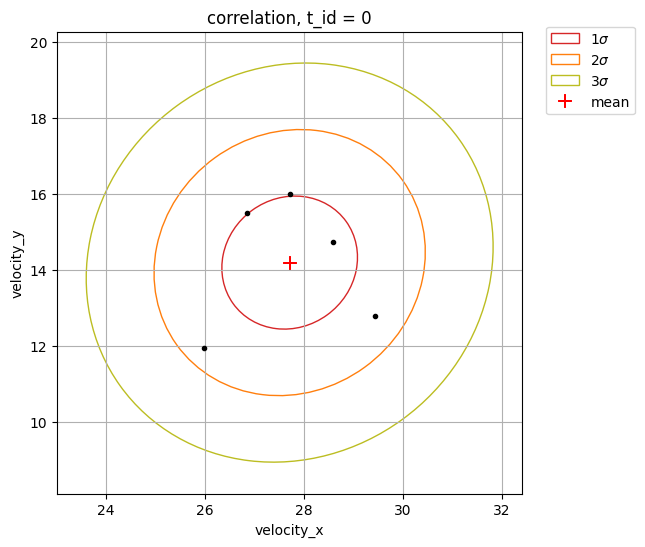

In [34]:
db_vel.show_correlation(x_col = 'velocity_x',  y_col = 'velocity_y', slice_id = 0, n_std = [1,2,3])

Let's display the coordinate slice in the middle of the flight. We can specify approximate value by 'slice_val'.
As the 't' axis is normalized to unit range, in the middle of the simulation it equals 0.5.

Let's get the parameter of the 3-sigma error ellipse and print them:

slice_id = 24,
slice_val = 0.4897959183673469
ellipse parameters:
center: 48.50360497287236, 12.9631945110204
width: 40.66800850736442, height: 3.356258025916703
angle: 9.229328995903753



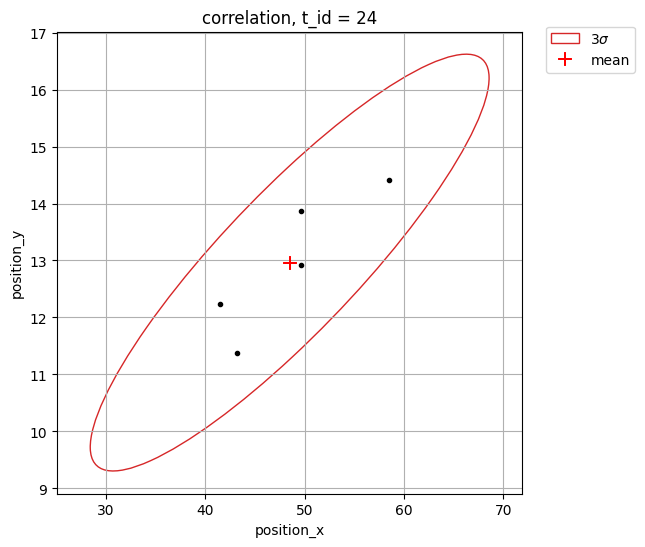

In [35]:
ellipse_param = db.show_correlation(x_col = 'position_x',  y_col = 'position_y', slice_val = 0.5, n_std = 3, return_ellipse_param = True)

print("ellipse parameters:")
print(f"center: {ellipse_param['x']}, {ellipse_param['y']}")
print(f"width: {ellipse_param['width']}, height: {ellipse_param['height']}")
print(f"angle: {ellipse_param['alpha']}\n")

If `bounding_error` = True, then the radius of the bounding error also may be printed:

slice_id = 24,
slice_val = 0.4897959183673469
radius of the error circle: 70.46792357282267



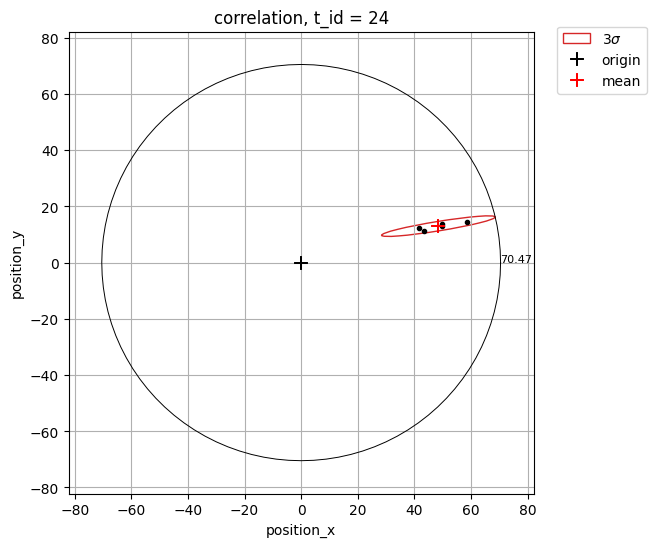

In [36]:
ellipse_param = db.show_correlation(x_col = 'position_x',  y_col = 'position_y', slice_val = 0.5, n_std = 3, 
                                    return_ellipse_param = True, bounding_error = True)

print(f"radius of the error circle: {ellipse_param['bounding_error']}\n")

## Validation

Let's query data in the same way as we did in [statistics](#statistics), but withdrow the last point in each simulation.
This way we will get only flight phase data before crash.
Also let's make a new column velocity and calculate distance from the initial point:

In [37]:
column_names = ['position_x', 'position_y', 'velocity_x', 'velocity_y']
query = ['data.data['+str(i)+']' for i in range(len(column_names))]

#get all possible sid:
sid_list = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').info()['sid_list']
print(f"sid numbers: {sid_list}")

#for each sid get the last rid:
rid_dict = {}
for s in sid_list:
    rid_dict[s] = citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid(s).get_max_value('rid')
print(f"rid last numbers: {rid_dict}")

#set constraints on by rid() method
import pandas as pd
F = pd.DataFrame()

for s, r in rid_dict.items():
    F = pd.concat([F, citros.simulation(my_simulation).batch(my_batch).topic('/cannon/state').sid(s).rid(end = r-1).data(query)])
F.rename({query[i]: column_names[i] for i in range(len(query))}, axis = 1, inplace = True)

dt = 0.01
F['t'] = F['rid']*dt

#calculate total velocity
import numpy as np
F['velocity'] = np.sqrt(F['velocity_x']**2+F['velocity_y']**2)
F['d'] = np.sqrt(F['position_x']**2+F['position_y']**2)

print(F.head(5))

sid numbers: [0, 1, 2, 3, 4]
rid last numbers: {0: 548, 1: 1473, 2: 582, 3: 640, 4: 650}
   sid  rid                 time          topic  \
0    0    0  1706082373402026613  /cannon/state   
1    0    1  1706082373402927205  /cannon/state   
2    0    2  1706082373410028644  /cannon/state   
3    0    3  1706082373417063208  /cannon/state   
4    0    5  1706082373426895756  /cannon/state   

                             type  velocity_y  position_y  position_x  \
0  std_msgs/msg/Float64MultiArray     11.9589    4.178630    8.054036   
1  std_msgs/msg/Float64MultiArray     11.8608    4.297728    8.313844   
2  std_msgs/msg/Float64MultiArray     11.7627    4.415846    8.573651   
3  std_msgs/msg/Float64MultiArray     11.6646    4.532982    8.833459   
4  std_msgs/msg/Float64MultiArray     11.5665    4.649138    9.093267   

   velocity_x     t   velocity          d  
0   25.980762  0.00  28.600967   9.073502  
1   25.980762  0.01  28.560087   9.358978  
2   25.980762  0.02  28.519487   

In [38]:
from citros_data_analysis import validation as va

Construct Validation object. It determines how the data will be preprocessed:

- `data_label` determine data columns, 
- `param_label` is for independent variable that will be used for setting correspondence between different sids and 
- `method` determines the method of index assignment:
  - 'scale': by scaling 'param_label' to unit interval and interpolating data on this interval,
  - 'bin': by deviding 'param_label' on bins and calculating mean data values among points falled in each bin, 
- `num` determines number of points if method set as 'scale' or bins if 'method' set as 'bin':

In [39]:
V = va.Validation(F, data_label = ['velocity_x', 'velocity_y'], param_label = 't', method = 'scale', num = 50)

### Check velocity standard deviation boundary

Let's check if the difference in velocities among the simulations is not too much, say the standard deviation boundary for x velocity 
component is within the inteval -10 to 80 and from -70 to 70 for y velocity component:


- `limits`: 
  - a one value to set the same +-limits to elements of the vector, for examples limits = 0.25
  - list of values to set +-limits for each vector element, for examples limits = [0.25, 0.5, 100]
  - list of lists to set lower and upper intervals separately, for examples limits = [0.25, [-0.3, 0.8], [-150, 100]]
- `n_std`: number of standard deviations in standard deviation boundary
- `nan_passed`: whether nan values are treated as passed test or not
- to style the plot:
  - `std_area` - set True to fill with color standard deviation boundary
  - `std_lines` - set False to remove standard deviation boundary lines
  - `std_color` - set standard deviation boundary color, default 'b'

std_bound_test: passed


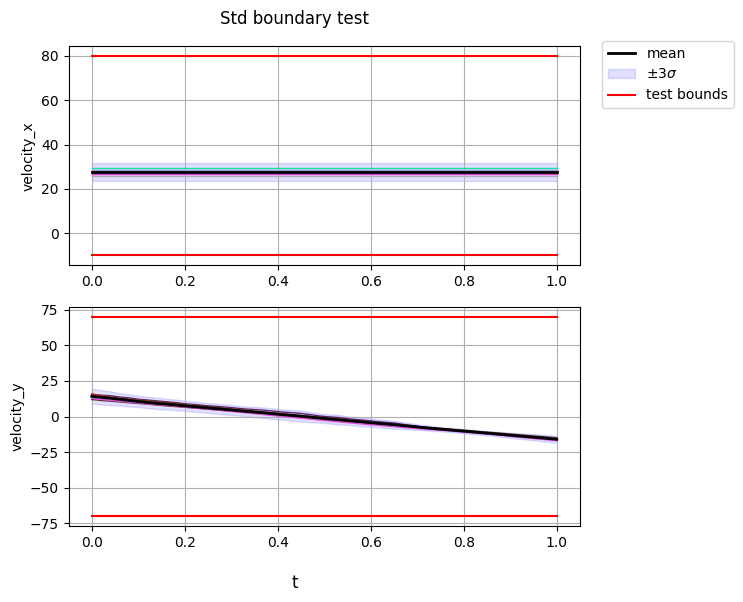

In [40]:
log, table, fig = V.std_bound_test(limits = [[-10, 80], 70], n_std = 3, std_area = True, std_lines = False, std_color = 'b')

### Check velocity standard deviation

We can check that the standard deviation values themselves do not exceed the limits, for example that 1 sigma < 15 for both velocities:

std_test: passed


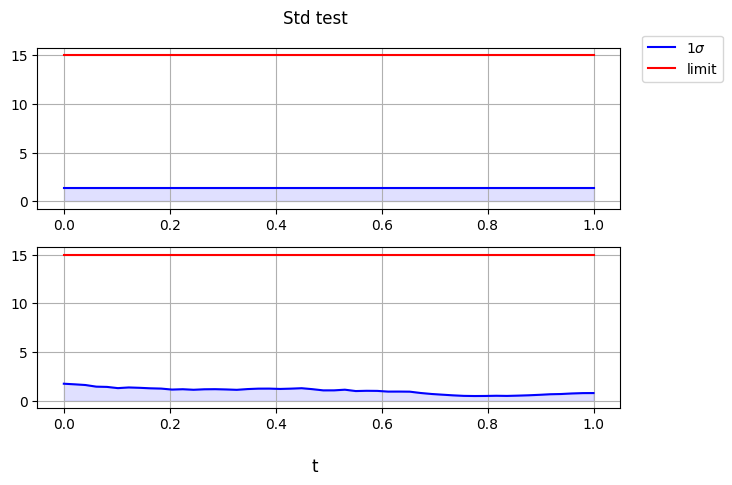

In [41]:
log, table, fig = V.std_test(limits = 15, n_std = 1, std_area = True, std_lines = True, std_color = 'b')

### Check mean velocity value

Let's check if the mean total valocity is always within the limits [30, 60]:

In [42]:
V = va.Validation(F, data_label = ['velocity'], param_label = 't', method = 'scale', num = 50)

mean_test: passed


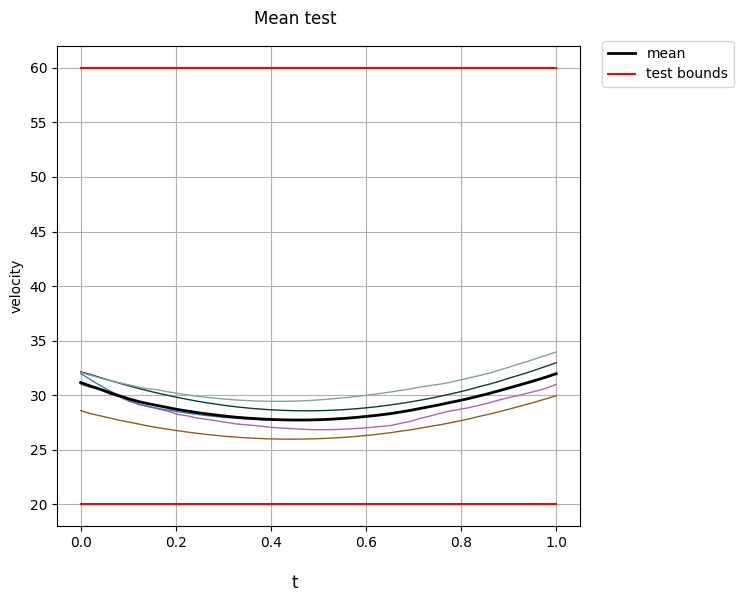

In [43]:
log, table, fig = V.mean_test(limits = [20, 60])

Some points of the individual simulations may exceed the limits, but the test will be still passed as long as the mean values are within limit.

### Check velocity of each simulation

sid_test: passed


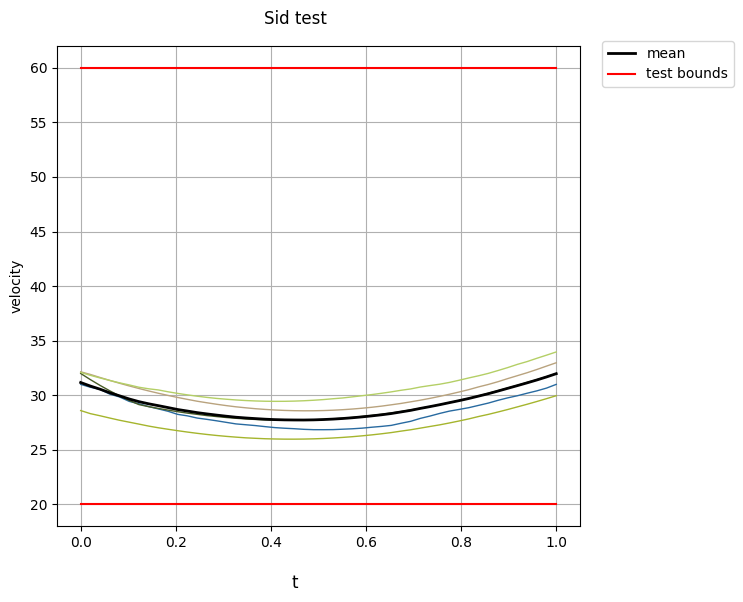

In [44]:
log, table, fig = V.sid_test(limits = [20, 60])

Some simulations may not pass the test. Print the report of the test to learn more:

In [45]:
log.print()

{
 'test_param': {
   'limits': [20, 60]
 },
 'velocity': {
   'passed': True,
   'pass_rate': {
     'sid_fraction': 1.0,
     0: 1.0,
     1: 1.0,
     2: 1.0,
     3: 1.0,
     4: 1.0
   },
   'failed': {
   }
 }
}


We can see which fraction of the simulations pass the test and also the details about each simulation pass rate.

Let's display fraction of points, which passed the test, and indices and x values of the failed points for the simulation 2:

In [46]:
total_pass_rate = log['velocity']['pass_rate']['sid_fraction']
pass_rate_sid_2 = log['velocity']['pass_rate'][2]

print(f"Test was passed by {total_pass_rate*100} per cent of simulations")
print(f"{pass_rate_sid_2*100} per cent of points of the simulation 2 passed the test")
print("indices and corresponding to them independent value of the points that failed test:")
log['velocity']['failed'][2].print()

Test was passed by 100.0 per cent of simulations
100.0 per cent of points of the simulation 2 passed the test
indices and corresponding to them independent value of the points that failed test:


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4 print(f"Test was passed by {total_pass_rate*100} per cent of simulations")                   │
│   5 print(f"{pass_rate_sid_2*100} per cent of points of the simulation 2 passed the test")       │
│   6 print("indices and corresponding to them independent value of the points that failed tes     │
│ ❱ 7 log['velocity']['failed'][2].print()                                                         │
│   8                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 2

One of the returned parameters is a DataFrame, each cell indicates whether the correspondingh point passes the test or not:

In [47]:
print(table.xs(2, level = 'sid').head(5)) #method head(n) return first n rows of the DataFrame table

             t  velocity
t_id                    
0     0.000000      True
1     0.020408      True
2     0.040816      True
3     0.061224      True
4     0.081633      True


### Check maximum distance

Test if the distance of each simulation do not exceed the limit, for example 50

We will use norm test, where the norm is defined as the absolute maximum - Linf norm

norm_test Linf: passed


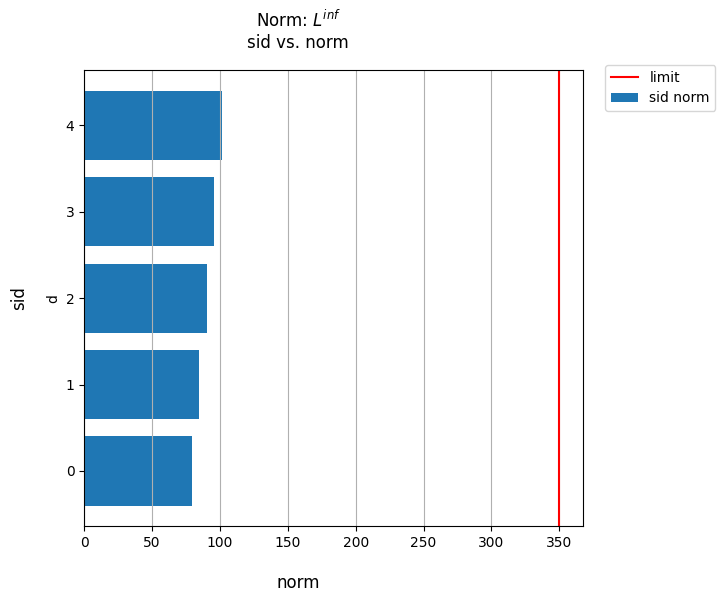

In [48]:
V = va.Validation(F, data_label = ['d'], param_label = 't', method = 'scale', num = 50)

log, table, fig = V.norm_test(norm_type = 'Linf', limits = 350)